In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [4]:
query_datavalue = text("""SELECT date, time_slot, SUM(datavalue) AS datavalue
    FROM (
        SELECT 
            DATE(datefrom) AS date,
            CASE
                WHEN EXTRACT(HOUR FROM datefrom) BETWEEN 0 AND 5 THEN '00-05'
                WHEN EXTRACT(HOUR FROM datefrom) BETWEEN 6 AND 11 THEN '06-11'
                WHEN EXTRACT(HOUR FROM datefrom) BETWEEN 12 AND 17 THEN '12-17'
                WHEN EXTRACT(HOUR FROM datefrom) BETWEEN 18 AND 23 THEN '18-23'
            END AS time_slot,
            datavalue
        FROM movements
    ) AS sub
    GROUP BY date, time_slot
    ORDER BY date, time_slot;""")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_datavalue, connection, chunksize=1000) 
        df_datavalue = pd.concat(chunks, ignore_index=True) 
    print(df_datavalue)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

           date time_slot  datavalue
0    2019-08-01     00-05     489692
1    2019-08-01     06-11    2108422
2    2019-08-01     12-17    2199244
3    2019-08-01     18-23    1399123
4    2019-08-02     00-05     492885
..          ...       ...        ...
239  2019-09-29     18-23    1317350
240  2019-09-30     00-05     402450
241  2019-09-30     06-11    2344364
242  2019-09-30     12-17    2580491
243  2019-09-30     18-23    1314627

[244 rows x 3 columns]


Heatmap – Giorni vs Fasce orarie

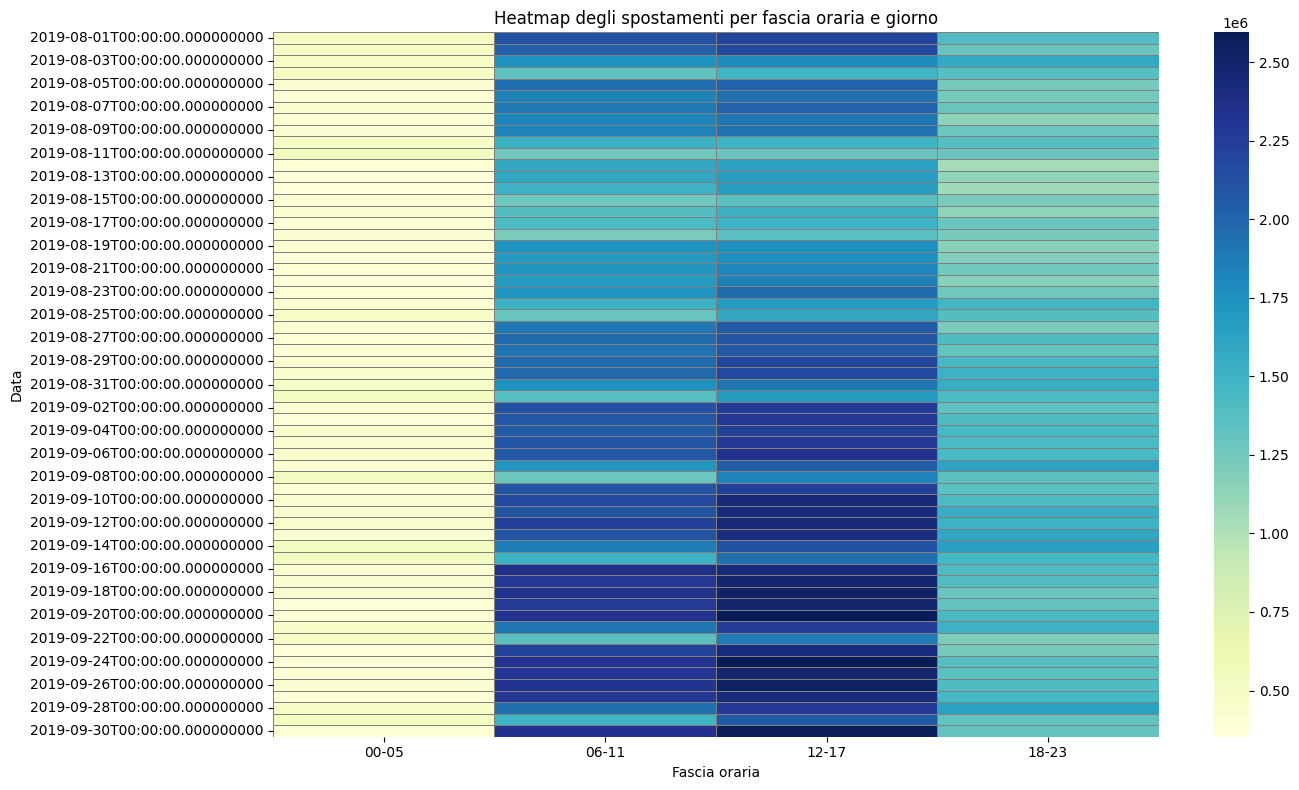

In [6]:
# Assicurati che 'date' sia in formato datetime
df_datavalue['date'] = pd.to_datetime(df_datavalue['date'])

# Pivot per heatmap: righe = date, colonne = time_slot
pivot_heatmap = df_datavalue.pivot(index='date', columns='time_slot', values='datavalue')

# Ordina le colonne manualmente per fascia oraria
pivot_heatmap = pivot_heatmap[['00-05', '06-11', '12-17', '18-23']]

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_heatmap, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title("Heatmap degli spostamenti per fascia oraria e giorno")
plt.xlabel("Fascia oraria")
plt.ylabel("Data")
plt.tight_layout()
plt.show()

 Grafico a barre stacked – Confronto tra fasce orarie per giorno

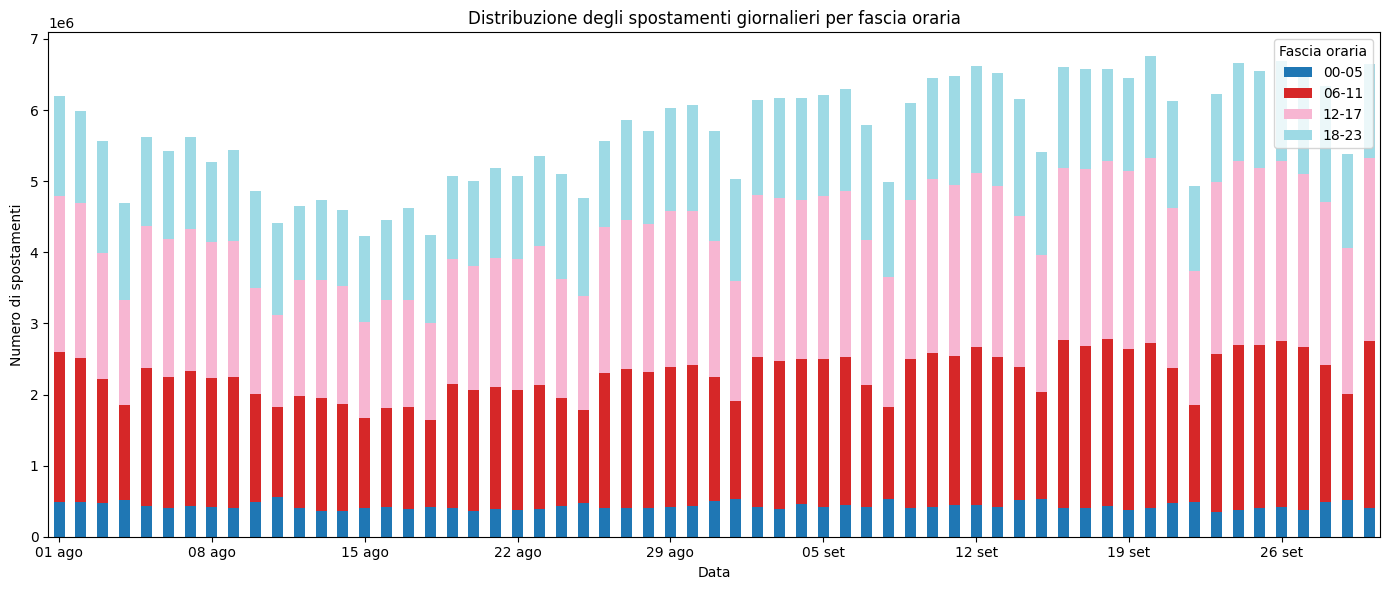

In [15]:
pivot_bar = df_datavalue.pivot_table(index='date', columns='time_slot', values='datavalue', aggfunc='sum')
# Ottieni le date da visualizzare ogni 7 giorni
x_dates = pivot_bar.index[::7]
x_labels = [d.strftime('%d %b').replace('Aug', 'ago').replace('Sep', 'set') for d in x_dates]

# Plot
ax = pivot_bar.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Distribuzione degli spostamenti giornalieri per fascia oraria")
plt.xlabel("Data")
plt.ylabel("Numero di spostamenti")
plt.legend(title="Fascia oraria")

# Applica le etichette manuali in italiano
ax.set_xticks(range(0, len(pivot_bar.index), 7))
ax.set_xticklabels(x_labels, rotation=0)

plt.tight_layout()
plt.show()
